**Master IASD**

**Deep Learning for Image Analisis**

**Practical Session Oct 3-2025**
Deadline: Oct 10 / 2025

*The final assessment is graded on a 20-point scale: each question is worth 1 point, except the final question, which is worth 5 points.*

Santiago VELASCO-FORERO
santiago.velasco@minesparis.psl.eu

Teaching assistant:

Camille ROBIN (camille.robin@minesparis.psl.eu)

Pierre ONGHENA (pierre.onghena@minesparis.psl.eu)



In this notebook, we aim to examine the impact of the learning rate and certain architectural choices on the training process of a CNN. It should be noted that drawing general conclusions is difficult, as the experiments are influenced by factors such as random batch selection, random initialization of learnable parameters, and other sources of variability.

This notebook was built with PyTorch. If you’re new to PyTorch, we recommend going through the tutorial available at https://docs.pytorch.org/tutorials/beginner/basics/intro.html

Another references:

https://d2l.ai/

In [17]:
!pip install torchinfo
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from sklearn.metrics import classification_report

print(torch.__version__)  # Prints the PyTorch version

#If you’re using a GPU, you can check availability with:
print('If GPU available', torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


NEPOCHS=48

2.8.0+cu126
If GPU available True


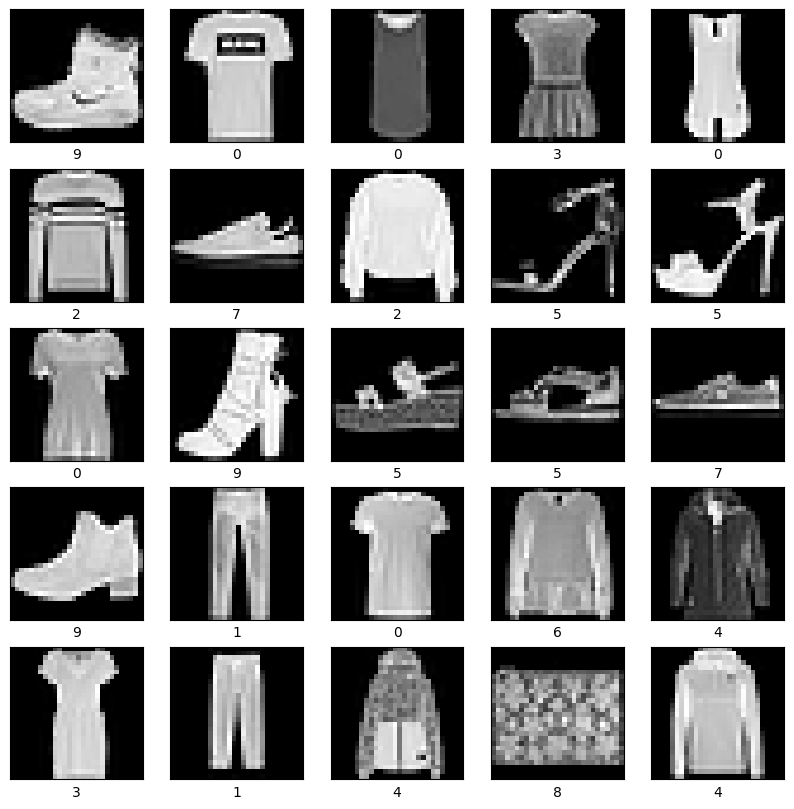

(28, 28)


In [18]:
#Define transforms for training and test data
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5)  # 50% chance of flipping
])

test_transform = transforms.Compose([
    transforms.ToTensor()
])

# Load Fashion-MNIST dataset

train_data = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=train_transform  # Use augmented transform for training
)
test_data = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=test_transform  # No augmentation for test data
)

# Convert to numpy arrays for visualization (PyTorch tensors are similar to numpy arrays)
train_images = train_data.data.numpy()
train_labels = train_data.targets.numpy()
test_images = test_data.data.numpy()
test_labels = test_data.targets.numpy()

# Normalize images (same as in Keras)
train_images = train_images / 255.0
test_images = test_images / 255.0

# Visualize some examples
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

print(train_images[i].shape)

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class FashionMNISTModel(nn.Module):
    def __init__(self, input_shape, num_classes):
        """
        Initialize the FashionMNIST CNN model.

        Args:
            input_shape (tuple): Shape of input images as (channels, height, width).
            num_classes (int): Number of output classes (10 for Fashion-MNIST).
        """
        # Call the parent class (nn.Module) constructor
        super(FashionMNISTModel, self).__init__()

        # --- Convolutional Layers ---
        # Conv1: Input channels = input_shape[0], Output channels = 16, Kernel = 3x3, Stride = 1, Padding = 1
        # Padding=1 ensures spatial dimensions are preserved (output size = input size)
        self.conv1 = nn.Conv2d(input_shape[0], 16, kernel_size=3, stride=1, padding=1)

        # Conv2: Input channels = 16, Output channels = 32, Kernel = 3x3, Stride = 1, Padding = 1
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

        # MaxPool: Reduces spatial dimensions by half (kernel=2, stride=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv3: Input channels = 32, Output channels = 64, Kernel = 3x3, Stride = 1, Padding = 1
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # Conv4: Input channels = 64, Output channels = 96, Kernel = 3x3, Stride = 1, Padding = 1
        self.conv4 = nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1)

        # Global Average Pooling: Reduces each feature map to a single value (output size = 1x1)
        self.globalpool = nn.AdaptiveAvgPool2d(1)

        # Fully Connected Layer: Input features = 96 (from conv4), Output features = num_classes
        self.dense = nn.Linear(96, num_classes)

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).

        Returns:
            torch.Tensor: Output logits of shape (batch_size, num_classes).
        """
        # Apply Conv1 + ReLU activation
        x = F.relu(self.conv1(x))

        # Apply Conv2 + ReLU activation
        x = F.relu(self.conv2(x))

        # Apply MaxPooling to reduce spatial dimensions
        x = self.pool(x)

        # Apply Conv3 + ReLU activation
        x = F.relu(self.conv3(x))

        # Apply Conv4 + ReLU activation
        x = F.relu(self.conv4(x))

        # Apply Global Average Pooling to get a 1x1 feature map per channel
        x = self.globalpool(x)

        # Flatten the output for the fully connected layer
        # x.size(0) = batch size, -1 = flatten all other dimensions
        x = x.view(x.size(0), -1)

        # Apply the fully connected layer to get class logits
        x = self.dense(x)

        return x


In [20]:
model0=FashionMNISTModel((1,28,28),10)
print(model0)

FashionMNISTModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (globalpool): AdaptiveAvgPool2d(output_size=1)
  (dense): Linear(in_features=96, out_features=10, bias=True)
)


In [21]:
def print_layer_parameters(model):
    """
    Prints the number of parameters for each layer in the model.
    Args:
        model (nn.Module): PyTorch model whose parameters are to be printed.
    """
    for name, param in model.named_parameters():
        # Only consider parameters that require gradients (trainable parameters)
        if param.requires_grad:
            # name: Name of the parameter (e.g., 'conv1.weight')
            # param.numel(): Number of elements in the parameter tensor
            print(f"Layer: {name} | Parameters: {param.numel()}")



In [22]:
def print_layer_parameters_summary(model):
    """
    Prints the total number of parameters for each layer (grouping weights and biases).
    Args:
        model (nn.Module): PyTorch model whose parameters are to be summarized.
    """
    for name, module in model.named_children():
        # Sum the number of elements in all parameters of the current module
        # (both weights and biases, if they exist)
        params = sum(p.numel() for p in module.parameters() if p.requires_grad)
        # Print the layer name and total parameters
        print(f"Layer: {name} | Total Parameters: {params}")

def print_total_trainable_parameters(model):
    """
    Prints the total number of parameters of the model.
    Args:
        model (nn.Module): PyTorch model whose parameters are to be summarized.
    """
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {total_params}")
    return total_params

### Code Explanation

**model.named_parameters():**
Iterates over all parameters, returning both the name (e.g., 'conv1.weight') and the parameter tensor.

**param.requires_grad:**
Ensures only trainable parameters are counted (excludes frozen layers).

**param.numel():**
Returns the total number of elements in the parameter tensor (e.g., weights or biases).

**model.named_children():**
Iterates over immediate child modules (layers) of the model, useful for grouping weights and biases of a layer together.

**sum(p.numel() for p in module.parameters() if p.requires_grad):**
Sums the number of elements in all parameters of a layer (both weights and biases).

**total_params:**
Sums all trainable parameters in the model, giving the total model size.

In [23]:
# Example usage:
print_total_trainable_parameters(model0)

Total trainable parameters: 79658


79658

**Question 1:** Explain for each layer how the number of parameters is calculated.

Number of parameters in a CONV layer would be : ((m * n * d)+1)* k. Where:


*   m = shape of width of the filter
*   n = shape of height of the filter
*   d = number of filters in the previous layer
*   k = number of filters

added 1 because of the bias term for each filter.


First Layer: ((3 * 3 * 1) + 1) * 16 = 160

Second Layer: ((3 * 3 * 16) + 1) * 32 = 4640

MaxPool Layer = 0

Third Layer = ((3 * 3 * 32) + 1) * 64 = 18496

Fourth Layer = ((3 * 3 * 64) + 1) * 96 = 55392

Adaptive Pool Layer = 0

Last Linear Layer = (96 + 1) * 10 = 970

Total number of Parameters = 160 + 4640 + 18496 + 55392 + 970 = 79658


In [24]:
#!pip install torchinfo

In [25]:
import torch.nn as nn
from torchinfo import summary  # For model summary (install with: pip install torchinfo)
summary(model0, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
FashionMNISTModel                        [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 28, 28]           160
├─Conv2d: 1-2                            [1, 32, 28, 28]           4,640
├─MaxPool2d: 1-3                         [1, 32, 14, 14]           --
├─Conv2d: 1-4                            [1, 64, 14, 14]           18,496
├─Conv2d: 1-5                            [1, 96, 14, 14]           55,392
├─AdaptiveAvgPool2d: 1-6                 [1, 96, 1, 1]             --
├─Linear: 1-7                            [1, 10]                   970
Total params: 79,658
Trainable params: 79,658
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 18.25
Input size (MB): 0.00
Forward/backward pass size (MB): 0.55
Params size (MB): 0.32
Estimated Total Size (MB): 0.87

In [26]:
def configure_model(
    model: torch.nn.Module,
    optimizer_name: str = "sgd",
    learning_rate: float = 1.0,
    loss_type: str = "cross_entropy",
    **optimizer_kwargs,
) -> tuple[torch.optim.Optimizer, torch.nn.Module]:
    """
    Configures the optimizer and loss function for a PyTorch model.

    Args:
        model: PyTorch model to configure.
        optimizer_name: Name of the optimizer ('sgd', 'adam', 'rmsprop').
        learning_rate: Learning rate for the optimizer.
        loss_type: Type of loss function ('cross_entropy', 'mse', 'bce').
        **optimizer_kwargs: Additional keyword arguments for the optimizer.

    Returns:
        tuple: (optimizer, criterion)

    Example:
        optimizer, criterion = configure_model(
            model, optimizer_name="adam", learning_rate=0.001
        )
    """
    # --- Optimizer ---
    optimizers = {
        "sgd": torch.optim.SGD,
        "adam": torch.optim.Adam,
        "rmsprop": torch.optim.RMSprop,
    }
    if optimizer_name not in optimizers:
        raise ValueError(f"Optimizer {optimizer_name} not supported. Choose from: {list(optimizers.keys())}")
    optimizer = optimizers[optimizer_name](model.parameters(), lr=learning_rate, **optimizer_kwargs)

    # --- Loss Function ---
    if loss_type == "cross_entropy":
        criterion = torch.nn.CrossEntropyLoss()
    elif loss_type == "mse":
        criterion = torch.nn.MSELoss()
    elif loss_type == "bce":
        criterion = torch.nn.BCELoss()
    else:
        raise ValueError(f"Loss {loss_type} not supported. Choose from: 'cross_entropy', 'mse', 'bce'")

    return optimizer, criterion

In [27]:
optimizer, criterion = configure_model(model0,optimizer_name="sgd",learning_rate=1.0,loss_type="cross_entropy")

In [28]:
print(criterion)

CrossEntropyLoss()


In [29]:
def train_model(
    model: torch.nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    num_epochs: int,
    device: torch.device,
    verbose: bool = True,
    save_path: str = "best_model.pth",
) -> dict:
    """
    Train a PyTorch model and return training/validation metrics.

    Args:
        model: PyTorch model to train.
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        optimizer: Optimizer (e.g., SGD, Adam).
        criterion: Loss function (e.g., CrossEntropyLoss).
        num_epochs: Number of training epochs.
        device: Device to train on (CPU/GPU).
        verbose: If True, prints epoch progress.

    Returns:
        history: Dictionary containing training/validation metrics per epoch.
    """
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
    }

    model = model.to(device)
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train()
        train_loss, train_correct = 0.0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
            train_correct += (outputs.argmax(dim=1) == labels).sum().item()

        # --- Validation Phase ---
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                val_correct += (outputs.argmax(dim=1) == labels).sum().item()

        # --- Calculate Metrics ---
        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)

        # --- Store History ---
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)


        # --- Save Best Model ---
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            if verbose:
                print(f"Validation loss improved to {val_loss:.4f}. Model saved.")

        # --- Print Progress ---
        if verbose:
            print(
                f"Epoch {epoch+1}/{num_epochs}: "
                f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
            )

    # --- Load Best Model ---
    model.load_state_dict(torch.load(save_path))
    if verbose:
        print(f"Best validation loss: {best_val_loss:.4f}. Best model loaded.")

        # --- Print Progress ---
        if verbose:
            print(
                f"Epoch {epoch+1}/{num_epochs}: "
                f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
            )

    return history

In [30]:
from torch.utils.data import DataLoader, TensorDataset, random_split

# Convert numpy arrays to PyTorch tensors
train_images_tensor = torch.FloatTensor(train_images).unsqueeze(1)  # Add channel dim: [N, 28, 28] -> [N, 1, 28, 28]
train_labels_tensor = torch.LongTensor(train_labels)  # Use LongTensor for class indices

# Convert test data to tensors (no need to split)
test_images_tensor = torch.FloatTensor(test_images).unsqueeze(1)  # [M, 28, 28] -> [M, 1, 28, 28]
test_labels_tensor = torch.LongTensor(test_labels)

# Create a TensorDataset and split into train/validation
dataset = TensorDataset(train_images_tensor, train_labels_tensor)
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [31]:
# Call the training function
history0 = train_model(
    model=model0,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=NEPOCHS,
    device=device,
)

Validation loss improved to 2.3091. Model saved.
Epoch 1/48: Train Loss: 2.3120, Train Acc: 0.0994, Val Loss: 2.3091, Val Acc: 0.0998
Validation loss improved to 2.3054. Model saved.
Epoch 2/48: Train Loss: 2.3099, Train Acc: 0.0972, Val Loss: 2.3054, Val Acc: 0.1005
Epoch 3/48: Train Loss: 2.3096, Train Acc: 0.0996, Val Loss: 2.3078, Val Acc: 0.0991
Epoch 4/48: Train Loss: 2.3101, Train Acc: 0.0992, Val Loss: 2.3061, Val Acc: 0.1008
Epoch 5/48: Train Loss: 2.3097, Train Acc: 0.1011, Val Loss: 2.3085, Val Acc: 0.1008
Epoch 6/48: Train Loss: 2.3099, Train Acc: 0.1016, Val Loss: 2.3060, Val Acc: 0.1000
Epoch 7/48: Train Loss: 2.3101, Train Acc: 0.1015, Val Loss: 2.3090, Val Acc: 0.1022
Epoch 8/48: Train Loss: 2.3096, Train Acc: 0.1015, Val Loss: 2.3073, Val Acc: 0.1022
Epoch 9/48: Train Loss: 2.3100, Train Acc: 0.0987, Val Loss: 2.3058, Val Acc: 0.0991
Epoch 10/48: Train Loss: 2.3101, Train Acc: 0.0995, Val Loss: 2.3055, Val Acc: 0.0998
Epoch 11/48: Train Loss: 2.3106, Train Acc: 0.0987,

In [32]:
def make_plot_history(history):
    """
    Visualize the training process by plotting accuracy and loss over epochs.

    Args:
        history (dict): Dictionary containing 'train_acc', 'val_acc', 'train_loss', 'val_loss' lists.
    """
    plt.figure(figsize=(10, 8))

    # Accuracy plot
    plt.subplot(2, 1, 1)
    plt.plot(history['train_acc'], label='Training')
    plt.plot(history['val_acc'], label='Validation')
    plt.grid('on')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')

    # Loss plot
    plt.subplot(2, 1, 2)
    plt.plot(history['train_loss'], label='Training')
    plt.plot(history['val_loss'], label='Validation')
    plt.grid('on')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

def make_model_analysis(model, x_test, y_test,device):
    """
    Evaluate a trained PyTorch model and generate a classification report.

    Args:
        model (nn.Module): Trained PyTorch model.
        x_test (torch.Tensor): Test images tensor (shape: [N, 1, 28, 28]).
        y_test (torch.Tensor): True labels tensor.
        device (torch.device): Device where the model is located (CPU/GPU).
    """
    # Set model to evaluation mode
    model.eval()

    # Move test data to the same device as the model
    x_test = x_test.to(device)

    # Get predictions
    with torch.no_grad():
        outputs = model(x_test)
        _, y_pred = torch.max(outputs, dim=1)  # Get predicted class indices

    # Move predictions and labels to CPU for numpy conversion
    y_pred = y_pred.cpu().numpy()
    y_test = y_test.numpy()

    print('Predicted Classes', np.unique(y_pred))
    print('Truth Classes', np.unique(y_test))

    # Class names for Fashion MNIST
    target_names = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

    # Generate and print classification report
    print(classification_report(y_test, y_pred, target_names=target_names))

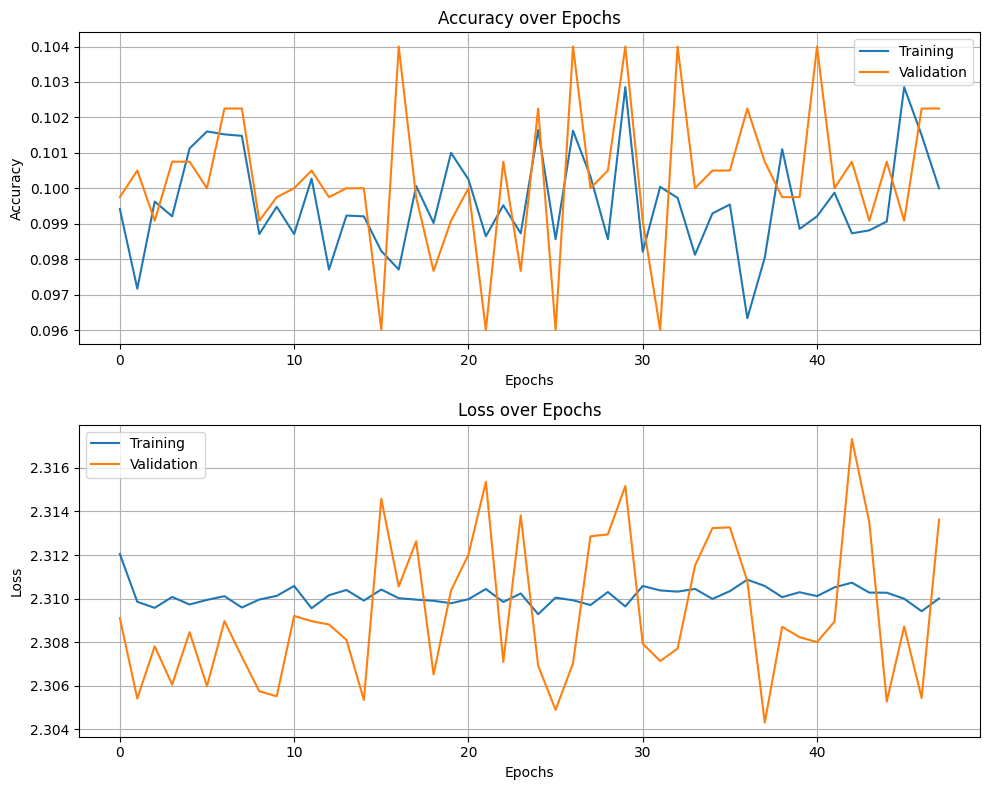

In [33]:
make_plot_history(history0)

In [34]:
make_model_analysis(model0, test_images_tensor, test_labels_tensor,device=device)

Predicted Classes [3]
Truth Classes [0 1 2 3 4 5 6 7 8 9]
              precision    recall  f1-score   support

     T-Shirt       0.00      0.00      0.00      1000
     Trouser       0.00      0.00      0.00      1000
    Pullover       0.00      0.00      0.00      1000
       Dress       0.10      1.00      0.18      1000
        Coat       0.00      0.00      0.00      1000
      Sandal       0.00      0.00      0.00      1000
       Shirt       0.00      0.00      0.00      1000
     Sneaker       0.00      0.00      0.00      1000
         Bag       0.00      0.00      0.00      1000
  Ankle Boot       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Question 2:** Is this model learning well?

No it is not. The reason is that the learning rate is very high for this task and this architecture.

**Question 3** Change the learning_rate to a value of 0.001 and train a new model. Call this new model: model1

In [35]:
model1=FashionMNISTModel((1,28,28),10)
optimizer, criterion = configure_model(model1,optimizer_name="sgd",learning_rate=0.001,loss_type="cross_entropy")

In [36]:
# Call the training function
history1 = train_model(
    model=model1,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=NEPOCHS,
    device=device,
)

Validation loss improved to 2.3028. Model saved.
Epoch 1/48: Train Loss: 2.3030, Train Acc: 0.1010, Val Loss: 2.3028, Val Acc: 0.0960
Validation loss improved to 2.3020. Model saved.
Epoch 2/48: Train Loss: 2.3022, Train Acc: 0.1010, Val Loss: 2.3020, Val Acc: 0.0960
Validation loss improved to 2.3013. Model saved.
Epoch 3/48: Train Loss: 2.3015, Train Acc: 0.1154, Val Loss: 2.3013, Val Acc: 0.1740
Validation loss improved to 2.3004. Model saved.
Epoch 4/48: Train Loss: 2.3007, Train Acc: 0.1754, Val Loss: 2.3004, Val Acc: 0.1438
Validation loss improved to 2.2992. Model saved.
Epoch 5/48: Train Loss: 2.2997, Train Acc: 0.1199, Val Loss: 2.2992, Val Acc: 0.1018
Validation loss improved to 2.2977. Model saved.
Epoch 6/48: Train Loss: 2.2984, Train Acc: 0.0937, Val Loss: 2.2977, Val Acc: 0.1012
Validation loss improved to 2.2954. Model saved.
Epoch 7/48: Train Loss: 2.2966, Train Acc: 0.1088, Val Loss: 2.2954, Val Acc: 0.1103
Validation loss improved to 2.2917. Model saved.
Epoch 8/48: T

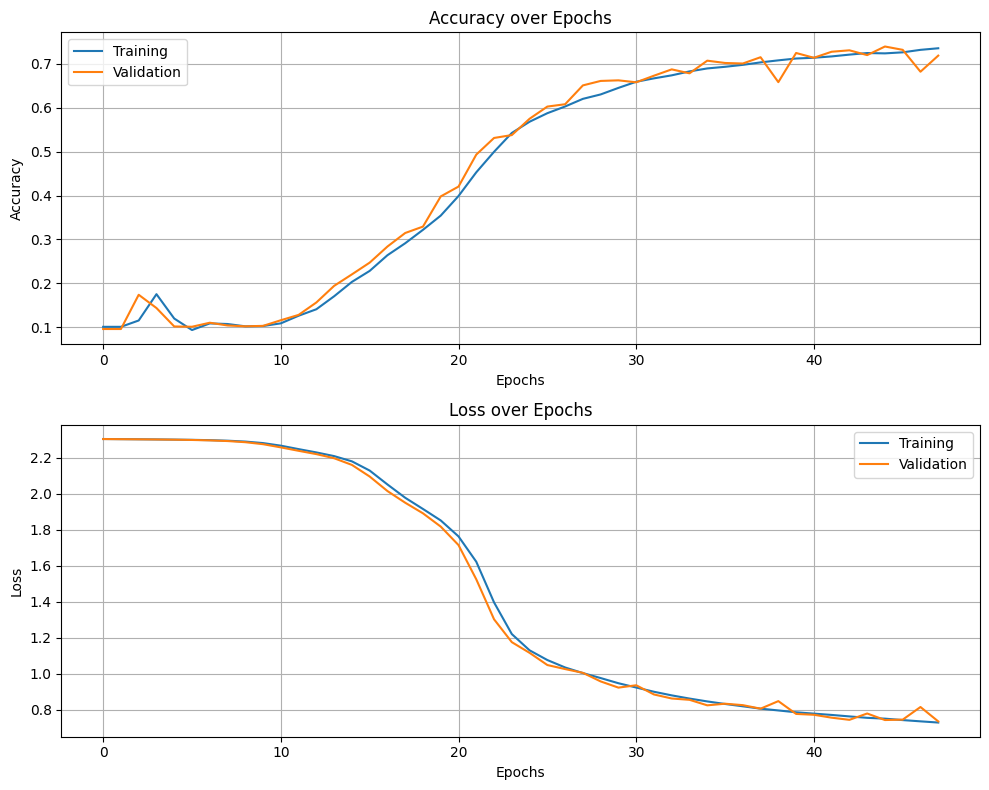

Predicted Classes [0 1 2 3 4 5 6 7 8 9]
Truth Classes [0 1 2 3 4 5 6 7 8 9]
              precision    recall  f1-score   support

     T-Shirt       0.62      0.81      0.71      1000
     Trouser       0.88      0.91      0.89      1000
    Pullover       0.45      0.81      0.58      1000
       Dress       0.74      0.65      0.69      1000
        Coat       0.59      0.50      0.54      1000
      Sandal       0.93      0.72      0.81      1000
       Shirt       0.42      0.06      0.11      1000
     Sneaker       0.77      0.91      0.83      1000
         Bag       0.93      0.90      0.91      1000
  Ankle Boot       0.83      0.89      0.86      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.69     10000
weighted avg       0.72      0.72      0.69     10000



In [37]:
make_plot_history(history1)
make_model_analysis(model1, test_images_tensor, test_labels_tensor,device=device)

**Question 4**. Keep the learning_rate 0.001. Change the optimizer from SGD to Adam. Call this model as "model2".

In [38]:
model2=FashionMNISTModel((1,28,28),10)
optimizer, criterion = configure_model(model2,optimizer_name='adam',learning_rate=0.001,loss_type="cross_entropy")

In [39]:
history2 = train_model(
    model=model2,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=NEPOCHS,
    device=device,
)

Validation loss improved to 0.6741. Model saved.
Epoch 1/48: Train Loss: 0.9401, Train Acc: 0.6486, Val Loss: 0.6741, Val Acc: 0.7618
Validation loss improved to 0.5754. Model saved.
Epoch 2/48: Train Loss: 0.6050, Train Acc: 0.7804, Val Loss: 0.5754, Val Acc: 0.7886
Validation loss improved to 0.5099. Model saved.
Epoch 3/48: Train Loss: 0.5154, Train Acc: 0.8147, Val Loss: 0.5099, Val Acc: 0.8117
Validation loss improved to 0.4576. Model saved.
Epoch 4/48: Train Loss: 0.4504, Train Acc: 0.8359, Val Loss: 0.4576, Val Acc: 0.8332
Validation loss improved to 0.4081. Model saved.
Epoch 5/48: Train Loss: 0.4098, Train Acc: 0.8505, Val Loss: 0.4081, Val Acc: 0.8536
Validation loss improved to 0.3523. Model saved.
Epoch 6/48: Train Loss: 0.3776, Train Acc: 0.8620, Val Loss: 0.3523, Val Acc: 0.8708
Validation loss improved to 0.3479. Model saved.
Epoch 7/48: Train Loss: 0.3541, Train Acc: 0.8700, Val Loss: 0.3479, Val Acc: 0.8747
Epoch 8/48: Train Loss: 0.3354, Train Acc: 0.8765, Val Loss: 0

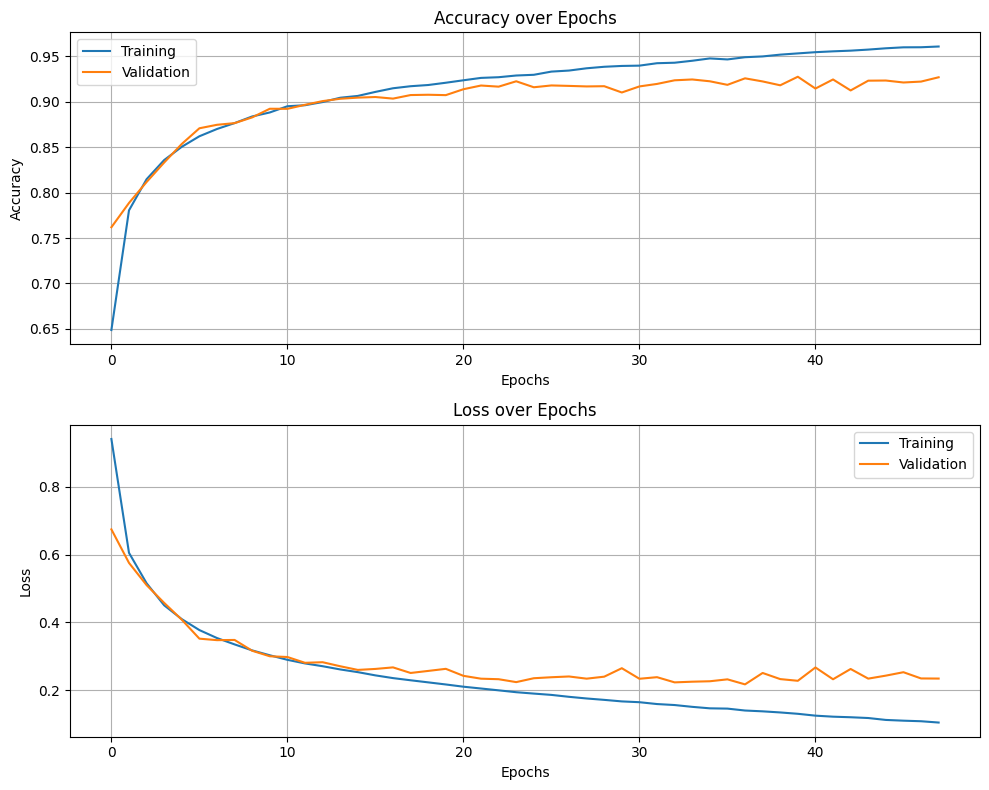

Predicted Classes [0 1 2 3 4 5 6 7 8 9]
Truth Classes [0 1 2 3 4 5 6 7 8 9]
              precision    recall  f1-score   support

     T-Shirt       0.86      0.86      0.86      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.89      0.89      0.89      1000
       Dress       0.91      0.91      0.91      1000
        Coat       0.87      0.89      0.88      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.78      0.75      0.76      1000
     Sneaker       0.94      0.98      0.96      1000
         Bag       0.98      0.99      0.98      1000
  Ankle Boot       0.98      0.95      0.96      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [40]:
make_plot_history(history2)
make_model_analysis(model2, test_images_tensor, test_labels_tensor,device=device)

**Question 5**: What is your analysis about the performance of model2?

Model2 (using Adam optimizer instead of SGD) showed significantly improved validation accuracy reaching above 92% compared to previous models with SGD. Training and validation losses decreased smoothly, indicating better convergence and generalization. This confirms that Adam optimizer leads to faster and more stable training for this problem.

**Question 6:**

Define a class FashionMNISTModelwithLayerNormalization to create a model as before but adding "LayerNormalization" layer in between each Conv2D and Activation layer. Do not include the bias in the convolution. Call this model as "model3" and check the number of parameter per layer.

https://docs.pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html



In [41]:
class FashionMNISTModelwithLayerNormalization(nn.Module):
    def __init__(self, input_shape, num_classes):
        """
        Initialize the FashionMNIST CNN model with Layer Normalization.

        Args:
            input_shape (tuple): Shape of input images as (channels, height, width).
            num_classes (int): Number of output classes (10 for Fashion-MNIST).
        """
        super(FashionMNISTModelwithLayerNormalization, self).__init__()

        # --- Convolutional Layers with Layer Normalization ---
        # Conv1 + LayerNorm
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=16, kernel_size=3, stride=1, padding=1)
        self.norm1 = nn.LayerNorm([16, 28, 28])


        # Conv2 + LayerNorm
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.norm2 = nn.LayerNorm([32, 28, 28])

        # MaxPool
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv3 + LayerNorm (spatial dims halved after pooling: 14x14)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.norm3 = nn.LayerNorm([64, 14, 14])

        # Conv4 + LayerNorm
        self.conv4 = nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1)
        self.norm4 = nn.LayerNorm([96, 14, 14])  # LayerNorm for Conv4 output shape: [batch, 96, 14, 14]

        # Global Average Pooling + Fully Connected
        self.globalpool = nn.AdaptiveAvgPool2d(1)
        self.dense = nn.Linear(96, num_classes)

    def forward(self, x):
        # Conv1 + LayerNorm + ReLU
        x = self.conv1(x)
        x = self.norm1(x)
        x = F.relu(x)

        # Conv2 + LayerNorm + ReLU
        x = self.conv2(x)
        x = self.norm2(x)
        x = F.relu(x)

        # MaxPool
        x = self.pool(x)

        # Conv3 + LayerNorm + ReLU
        x = self.conv3(x)
        x = self.norm3(x)
        x = F.relu(x)

        # Conv4 + LayerNorm + ReLU
        x = self.conv4(x)
        x = self.norm4(x)
        x = F.relu(x)

        # Global Average Pooling + Flatten + Dense
        x = self.globalpool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dense(x)

        return x

In [42]:
model3=FashionMNISTModelwithLayerNormalization((1,28,28),10)
summary(model3, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
FashionMNISTModelwithLayerNormalization  [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 28, 28]           160
├─LayerNorm: 1-2                         [1, 16, 28, 28]           25,088
├─Conv2d: 1-3                            [1, 32, 28, 28]           4,640
├─LayerNorm: 1-4                         [1, 32, 28, 28]           50,176
├─MaxPool2d: 1-5                         [1, 32, 14, 14]           --
├─Conv2d: 1-6                            [1, 64, 14, 14]           18,496
├─LayerNorm: 1-7                         [1, 64, 14, 14]           25,088
├─Conv2d: 1-8                            [1, 96, 14, 14]           55,392
├─LayerNorm: 1-9                         [1, 96, 14, 14]           37,632
├─AdaptiveAvgPool2d: 1-10                [1, 96, 1, 1]             --
├─Linear: 1-11                           [1, 10]                   970
Total params: 217,642
Trainable params: 217,642
Non-trai

In [43]:
optimizer, criterion = configure_model(model3,optimizer_name="adam",learning_rate=0.001,loss_type="cross_entropy")
history3 = train_model(
    model=model3,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=NEPOCHS,
    device=device,
)

Validation loss improved to 0.4355. Model saved.
Epoch 1/48: Train Loss: 0.7173, Train Acc: 0.7348, Val Loss: 0.4355, Val Acc: 0.8367
Validation loss improved to 0.3808. Model saved.
Epoch 2/48: Train Loss: 0.3850, Train Acc: 0.8592, Val Loss: 0.3808, Val Acc: 0.8627
Validation loss improved to 0.3059. Model saved.
Epoch 3/48: Train Loss: 0.3220, Train Acc: 0.8821, Val Loss: 0.3059, Val Acc: 0.8879
Validation loss improved to 0.3015. Model saved.
Epoch 4/48: Train Loss: 0.2878, Train Acc: 0.8950, Val Loss: 0.3015, Val Acc: 0.8939
Validation loss improved to 0.2995. Model saved.
Epoch 5/48: Train Loss: 0.2641, Train Acc: 0.9035, Val Loss: 0.2995, Val Acc: 0.8940
Validation loss improved to 0.2792. Model saved.
Epoch 6/48: Train Loss: 0.2465, Train Acc: 0.9114, Val Loss: 0.2792, Val Acc: 0.9003
Validation loss improved to 0.2489. Model saved.
Epoch 7/48: Train Loss: 0.2320, Train Acc: 0.9152, Val Loss: 0.2489, Val Acc: 0.9096
Epoch 8/48: Train Loss: 0.2190, Train Acc: 0.9195, Val Loss: 0

Text(0, 0.5, 'Validation Accuracy')

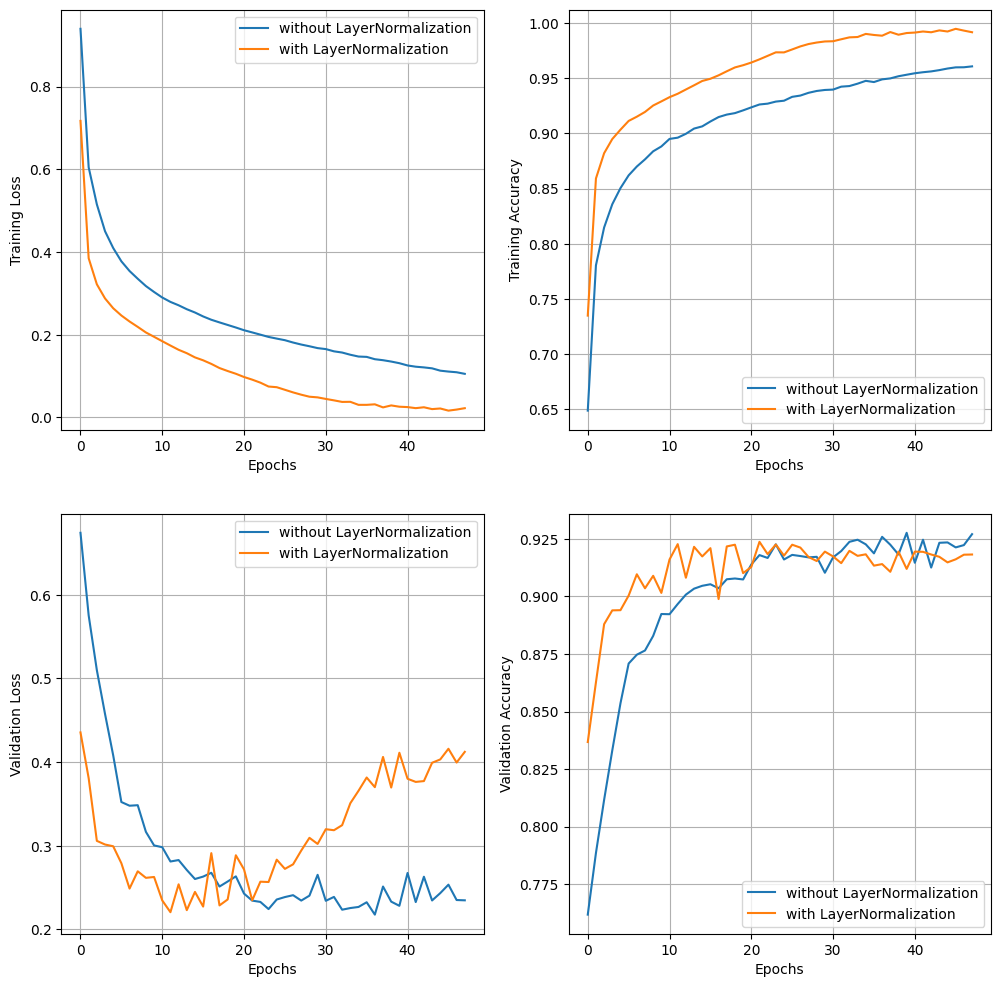

In [44]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.plot(history2['train_loss'],label='without LayerNormalization')
plt.plot(history3['train_loss'],label='with LayerNormalization')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.subplot(2,2,2)
plt.plot(history2['train_acc'],label='without LayerNormalization')
plt.plot(history3['train_acc'],label='with LayerNormalization')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.subplot(2,2,3)
plt.plot(history2['val_loss'],label='without LayerNormalization')
plt.plot(history3['val_loss'],label='with LayerNormalization')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.subplot(2,2,4)
plt.plot(history2['val_acc'],label='without LayerNormalization')
plt.plot(history3['val_acc'],label='with LayerNormalization')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

**Question 7:** What is your analysis about the performance of Model3?

Model3 (with Layer Normalization) improved training stability and reached validation accuracy around 91-92%. Although the number of parameters increased compared to model2, and also showed some decrease in validation accuracy and tend to overfit after a while (normalization leads to faster convergence but with too many epochs it leads to overfitting).

**Question 8:** Define a class FashionMNISTModelwithLayerNormalizationAndDropout to create a model as before but including a dropout layer after global pooling. Call this model as "model4"


https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html

In [45]:
class FashionMNISTModelwithLayerNormalizationAndDropout(nn.Module):
    def __init__(self, input_shape, num_classes, dropout_rate=0.5):
        """
        Initialize the FashionMNIST CNN model with Layer Normalization and Dropout.

        Args:
            input_shape (tuple): Shape of input images as (channels, height, width).
            num_classes (int): Number of output classes (10 for Fashion-MNIST).
            dropout_rate (float): Dropout probability (default: 0.5).
        """
        super(FashionMNISTModelwithLayerNormalizationAndDropout, self).__init__()

        # --- Convolutional Layers with Layer Normalization ---
        # Conv1 + LayerNorm
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=16, kernel_size=3, stride=1, padding=1)
        self.norm1 = nn.LayerNorm([16, 28, 28])

        # Conv2 + LayerNorm
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.norm2 = nn.LayerNorm([32, 28, 28])

        # MaxPool
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv3 + LayerNorm (spatial dims: 14x14 after pooling)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.norm3 = nn.LayerNorm([64, 14, 14])

        # Conv4 + LayerNorm
        self.conv4 = nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1)
        self.norm4 = nn.LayerNorm([96, 14, 14])

        # Global Average Pooling + Dropout + Fully Connected
        self.globalpool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(p=0.5)  # Dropout layer
        self.dense = nn.Linear(96, num_classes)

    def forward(self, x):
        # Conv1 + LayerNorm + ReLU
        x = self.conv1(x)
        x = self.norm1(x)
        x = F.relu(x)

        # Conv2 + LayerNorm + ReLU
        x = self.conv2(x)
        x = self.norm2(x)
        x = F.relu(x)

        # MaxPool
        x = self.pool(x)

        # Conv3 + LayerNorm + ReLU
        x = self.conv3(x)
        x = self.norm3(x)
        x = F.relu(x)

        # Conv4 + LayerNorm + ReLU
        x = self.conv4(x)
        x = self.norm4(x)
        x = F.relu(x)

        # Global Average Pooling + Dropout + Flatten + Dense
        x = self.globalpool(x)
        x = self.dropout(x)  # Apply dropout after pooling
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dense(x)

        return x

In [46]:
model4=FashionMNISTModelwithLayerNormalizationAndDropout((1,28,28),10)
summary(model4, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                             Output Shape              Param #
FashionMNISTModelwithLayerNormalizationAndDropout  [1, 10]                   --
├─Conv2d: 1-1                                      [1, 16, 28, 28]           160
├─LayerNorm: 1-2                                   [1, 16, 28, 28]           25,088
├─Conv2d: 1-3                                      [1, 32, 28, 28]           4,640
├─LayerNorm: 1-4                                   [1, 32, 28, 28]           50,176
├─MaxPool2d: 1-5                                   [1, 32, 14, 14]           --
├─Conv2d: 1-6                                      [1, 64, 14, 14]           18,496
├─LayerNorm: 1-7                                   [1, 64, 14, 14]           25,088
├─Conv2d: 1-8                                      [1, 96, 14, 14]           55,392
├─LayerNorm: 1-9                                   [1, 96, 14, 14]           37,632
├─AdaptiveAvgPool2d: 1-10                          [1, 96, 1, 1]             --
├─Dropo

In [47]:
optimizer, criterion = configure_model(model4,optimizer_name="adam",learning_rate=0.001,loss_type="cross_entropy")
history4 = train_model(
    model=model4,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=NEPOCHS,
    device=device,
)

Validation loss improved to 0.5188. Model saved.
Epoch 1/48: Train Loss: 0.8784, Train Acc: 0.6726, Val Loss: 0.5188, Val Acc: 0.8003
Validation loss improved to 0.4062. Model saved.
Epoch 2/48: Train Loss: 0.5150, Train Acc: 0.8135, Val Loss: 0.4062, Val Acc: 0.8473
Epoch 3/48: Train Loss: 0.4254, Train Acc: 0.8480, Val Loss: 0.4294, Val Acc: 0.8449
Validation loss improved to 0.3170. Model saved.
Epoch 4/48: Train Loss: 0.3766, Train Acc: 0.8639, Val Loss: 0.3170, Val Acc: 0.8823
Validation loss improved to 0.3033. Model saved.
Epoch 5/48: Train Loss: 0.3457, Train Acc: 0.8765, Val Loss: 0.3033, Val Acc: 0.8888
Epoch 6/48: Train Loss: 0.3190, Train Acc: 0.8846, Val Loss: 0.3125, Val Acc: 0.8863
Validation loss improved to 0.2795. Model saved.
Epoch 7/48: Train Loss: 0.3027, Train Acc: 0.8916, Val Loss: 0.2795, Val Acc: 0.8989
Validation loss improved to 0.2649. Model saved.
Epoch 8/48: Train Loss: 0.2880, Train Acc: 0.8971, Val Loss: 0.2649, Val Acc: 0.9042
Epoch 9/48: Train Loss: 0.

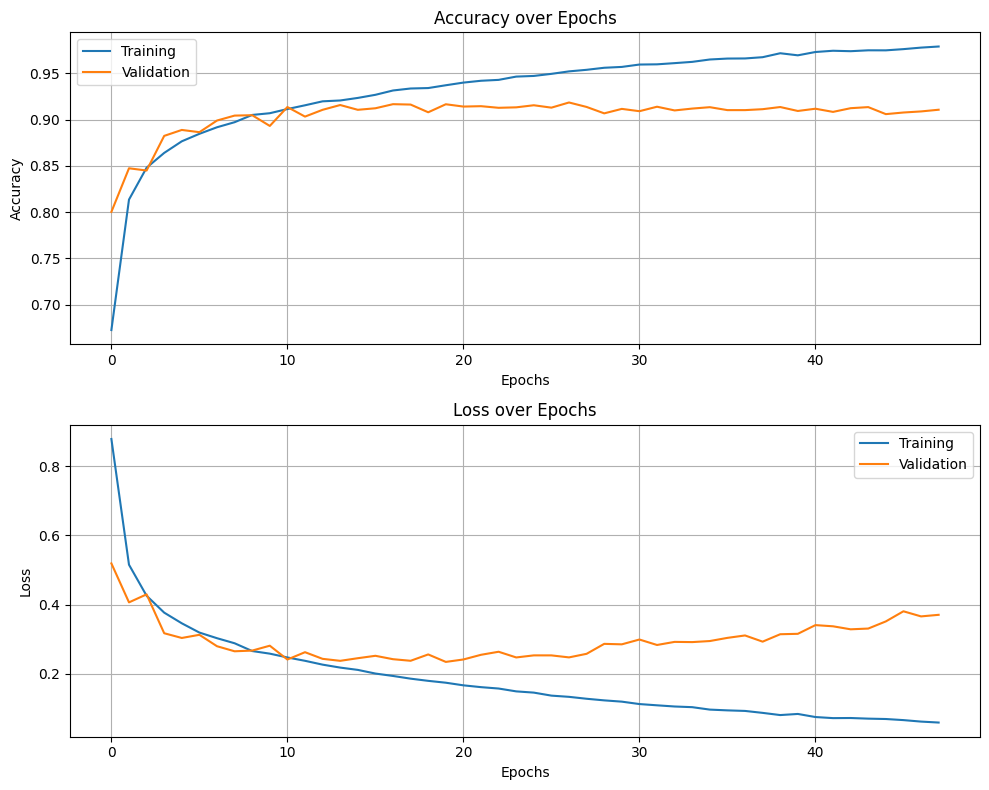

Predicted Classes [0 1 2 3 4 5 6 7 8 9]
Truth Classes [0 1 2 3 4 5 6 7 8 9]
              precision    recall  f1-score   support

     T-Shirt       0.84      0.89      0.86      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.86      0.88      0.87      1000
       Dress       0.93      0.90      0.91      1000
        Coat       0.88      0.84      0.86      1000
      Sandal       0.99      0.98      0.98      1000
       Shirt       0.74      0.74      0.74      1000
     Sneaker       0.96      0.98      0.97      1000
         Bag       0.99      0.98      0.98      1000
  Ankle Boot       0.97      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [48]:
make_plot_history(history4)
make_model_analysis(model4, test_images_tensor, test_labels_tensor,device=device)

Text(0, 0.5, 'Validation Accuracy')

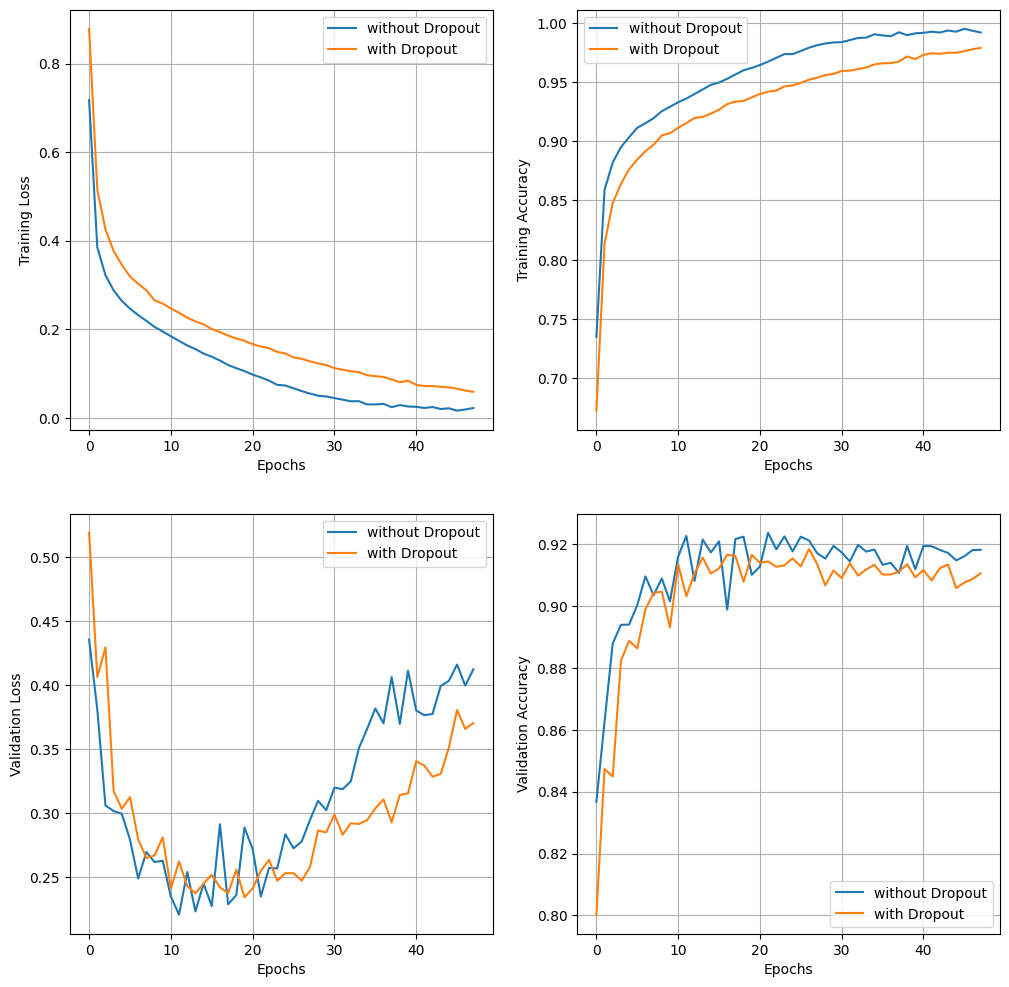

In [49]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.plot(history3['train_loss'],label='without Dropout')
plt.plot(history4['train_loss'],label='with Dropout')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.subplot(2,2,2)
plt.plot(history3['train_acc'],label='without Dropout')
plt.plot(history4['train_acc'],label='with Dropout')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.subplot(2,2,3)
plt.plot(history3['val_loss'],label='without Dropout')
plt.plot(history4['val_loss'],label='with Dropout')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.subplot(2,2,4)
plt.plot(history3['val_acc'],label='without Dropout')
plt.plot(history4['val_acc'],label='with Dropout')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

**Question 9**  
Compare all trained model in a plot of number of parameters and performance on test dataset.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.1 79658
0.7158 79658
0.918 79658
0.9116 217642
0.914 217642


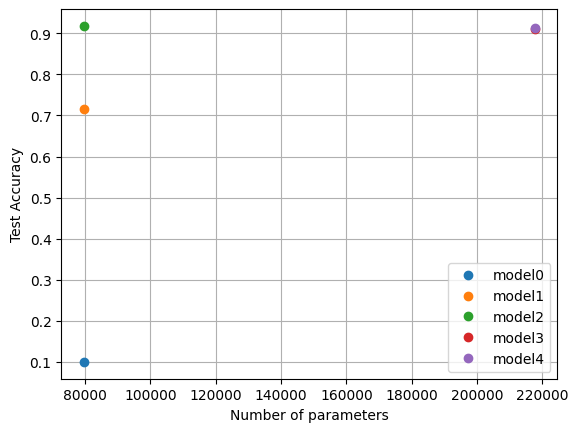

In [50]:
def make_model_analysis_parameters(model, x_test, y_test,device):
    """
    Evaluate a trained PyTorch model and generate a classification report.

    Args:
        model (nn.Module): Trained PyTorch model.
        x_test (torch.Tensor): Test images tensor (shape: [N, 1, 28, 28]).
        y_test (torch.Tensor): True labels tensor.
        device (torch.device): Device where the model is located (CPU/GPU).
    """
    # Set model to evaluation mode
    model.eval()

    # Move test data to the same device as the model
    x_test = x_test.to(device)

    # Get predictions
    with torch.no_grad():
        outputs = model(x_test)
        _, y_pred = torch.max(outputs, dim=1)  # Get predicted class indices

    # Move predictions and labels to CPU for numpy conversion
    y_pred = y_pred.cpu().numpy()
    y_test = y_test.numpy()

    # Class names for Fashion MNIST
    target_names = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

    # Generate and print classification report
    CR=classification_report(y_test, y_pred, target_names=target_names,output_dict=True)
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(CR['accuracy'],total_params)
    return CR['accuracy'],total_params



list_of_models=[model0,model1,model2,model3,model4]
res=[]
for model in list_of_models:
  acc,total_par=make_model_analysis_parameters(model, test_images_tensor, test_labels_tensor,device=device)
  res.append([acc,total_par])

for i in range(len(list_of_models)):
  plt.plot(res[i][1],res[i][0],'o',label='model'+str(i))
plt.xlabel('Number of parameters')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid()
plt.show()


In [51]:
print(model2)

FashionMNISTModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (globalpool): AdaptiveAvgPool2d(output_size=1)
  (dense): Linear(in_features=96, out_features=10, bias=True)
)


In [ ]:
class FashionMNISTModelwithBatchNormalization(nn.Module):
    def __init__(self, input_shape, num_classes):
        """
        Initialize the FashionMNIST CNN model with Batch Normalization.

        Args:
            input_shape (tuple): Shape of input images as (channels, height, width).
            num_classes (int): Number of output classes (10 for Fashion-MNIST).
        """
        super(FashionMNISTModelwithBatchNormalization, self).__init__()

        # --- Convolutional Layers with Batch Normalization ---
        # Conv1 + BatchNorm
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=16, kernel_size=3, stride=1, padding=1)
        self.norm1 = nn.BatchNorm2d(16)

        # Conv2 + BatchNorm
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.norm2 = nn.BatchNorm2d(32)

        # MaxPool
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv3 + BatchNorm (spatial dims: 14x14 after pooling)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.norm3 = nn.BatchNorm2d(64)

        # Conv4 + BatchNorm
        self.conv4 = nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1)
        self.norm4 = nn.BatchNorm2d(96)

        # Global Average Pooling + Dropout + Fully Connected
        self.globalpool = nn.AdaptiveAvgPool2d(1)
        self.dense = nn.Linear(96, num_classes)

    def forward(self, x):
        # Conv1 + BatchNorm + ReLU
        x = self.conv1(x)
        x = self.norm1(x)
        x = F.relu(x)

        # Conv2 + BatchNorm + ReLU
        x = self.conv2(x)
        x = self.norm2(x)
        x = F.relu(x)

        # MaxPool
        x = self.pool(x)

        # Conv3 + BatchNorm + ReLU
        x = self.conv3(x)
        x = self.norm3(x)
        x = F.relu(x)

        # Conv4 + BatchNorm + ReLU
        x = self.conv4(x)
        x = self.norm4(x)
        x = F.relu(x)

        # Global Average Pooling + Dropout + Flatten + Dense
        x = self.globalpool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dense(x)

        return x



In [53]:
model5 = FashionMNISTModelwithBatchNormalization((1, 28, 28), 10)
summary(model5, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
FashionMNISTModelwithBatchNormalization  [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 28, 28]           160
├─BatchNorm2d: 1-2                       [1, 16, 28, 28]           32
├─Conv2d: 1-3                            [1, 32, 28, 28]           4,640
├─BatchNorm2d: 1-4                       [1, 32, 28, 28]           64
├─MaxPool2d: 1-5                         [1, 32, 14, 14]           --
├─Conv2d: 1-6                            [1, 64, 14, 14]           18,496
├─BatchNorm2d: 1-7                       [1, 64, 14, 14]           128
├─Conv2d: 1-8                            [1, 96, 14, 14]           55,392
├─BatchNorm2d: 1-9                       [1, 96, 14, 14]           192
├─AdaptiveAvgPool2d: 1-10                [1, 96, 1, 1]             --
├─Linear: 1-11                           [1, 10]                   970
Total params: 80,074
Trainable params: 80,074
Non-trainable params: 0


In [54]:
optimizer, criterion = configure_model(model5, optimizer_name="adam", learning_rate=0.001, loss_type="cross_entropy")

In [55]:
history5 = train_model(
    model=model5,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=NEPOCHS,
    device=device,
)

Validation loss improved to 0.4341. Model saved.
Epoch 1/48: Train Loss: 0.6058, Train Acc: 0.7949, Val Loss: 0.4341, Val Acc: 0.8380
Epoch 2/48: Train Loss: 0.3549, Train Acc: 0.8744, Val Loss: 0.4820, Val Acc: 0.8240
Validation loss improved to 0.3241. Model saved.
Epoch 3/48: Train Loss: 0.3085, Train Acc: 0.8899, Val Loss: 0.3241, Val Acc: 0.8817
Validation loss improved to 0.2721. Model saved.
Epoch 4/48: Train Loss: 0.2765, Train Acc: 0.9023, Val Loss: 0.2721, Val Acc: 0.9052
Epoch 5/48: Train Loss: 0.2565, Train Acc: 0.9079, Val Loss: 0.2926, Val Acc: 0.8968
Epoch 6/48: Train Loss: 0.2425, Train Acc: 0.9134, Val Loss: 0.3009, Val Acc: 0.8937
Epoch 7/48: Train Loss: 0.2300, Train Acc: 0.9187, Val Loss: 0.3285, Val Acc: 0.8884
Epoch 8/48: Train Loss: 0.2190, Train Acc: 0.9214, Val Loss: 0.2895, Val Acc: 0.8941
Epoch 9/48: Train Loss: 0.2100, Train Acc: 0.9268, Val Loss: 0.3175, Val Acc: 0.8883
Validation loss improved to 0.2257. Model saved.
Epoch 10/48: Train Loss: 0.2008, Train 

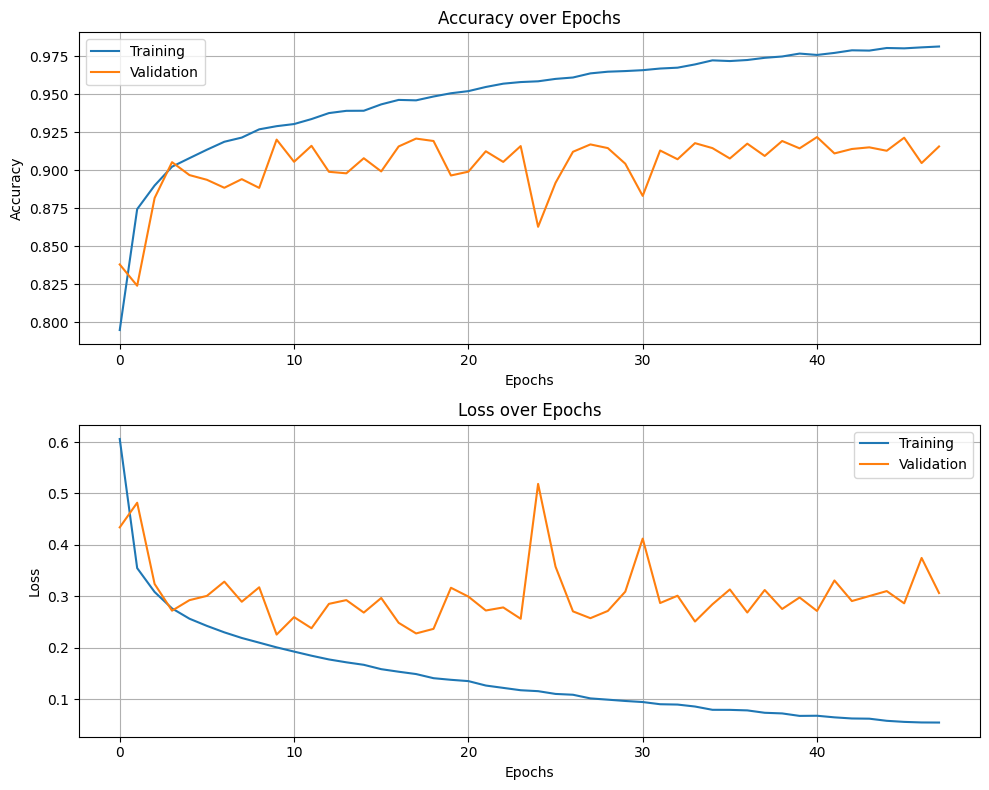

Predicted Classes [0 1 2 3 4 5 6 7 8 9]
Truth Classes [0 1 2 3 4 5 6 7 8 9]
              precision    recall  f1-score   support

     T-Shirt       0.87      0.86      0.87      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.84      0.93      0.88      1000
       Dress       0.88      0.92      0.90      1000
        Coat       0.87      0.89      0.88      1000
      Sandal       0.99      0.96      0.98      1000
       Shirt       0.82      0.70      0.76      1000
     Sneaker       0.94      0.99      0.96      1000
         Bag       0.99      0.99      0.99      1000
  Ankle Boot       0.97      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [56]:
make_plot_history(history5)
make_model_analysis(model5, test_images_tensor, test_labels_tensor, device=device)

Text(0, 0.5, 'Validation Accuracy')

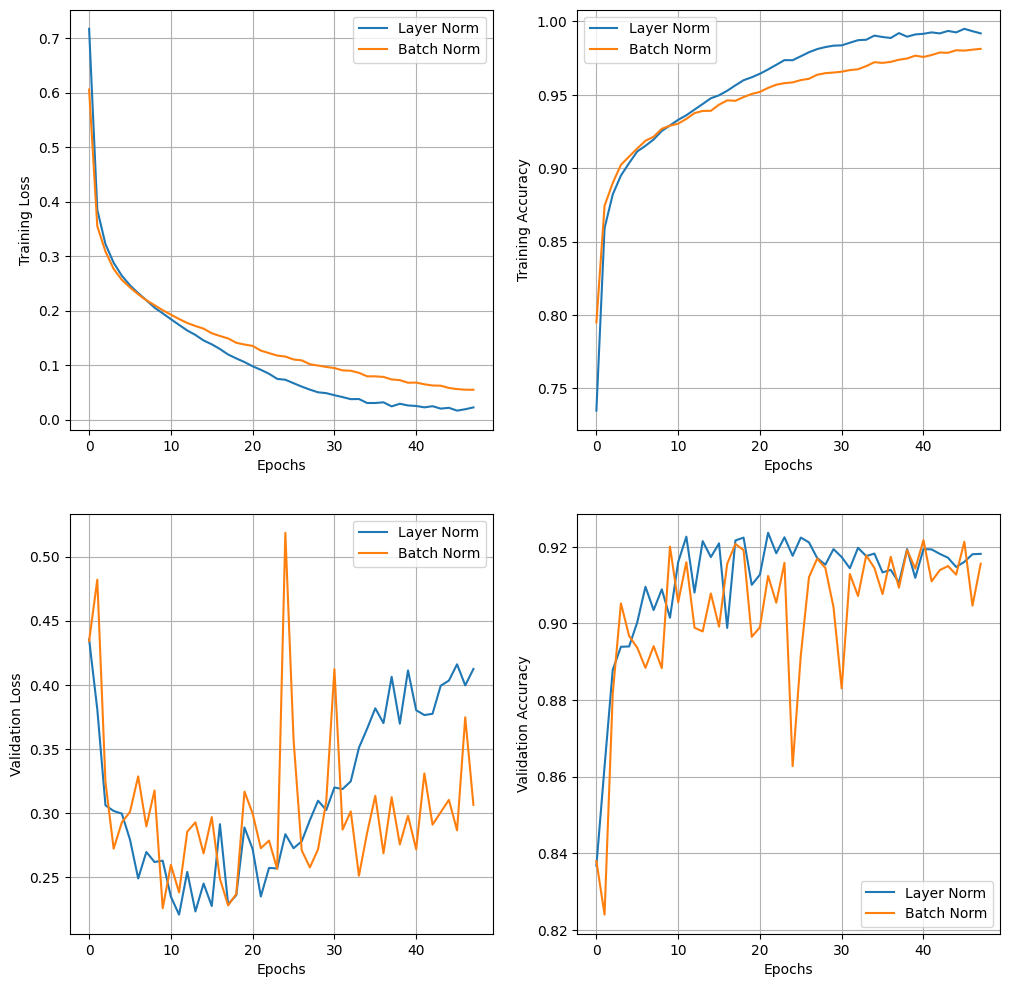

In [57]:
# Plot comparison between layer normalization (history3) and batch normalization (history4)
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(history3['train_loss'], label='Layer Norm')
plt.plot(history5['train_loss'], label='Batch Norm')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Training Loss')

plt.subplot(2, 2, 2)
plt.plot(history3['train_acc'], label='Layer Norm')
plt.plot(history5['train_acc'], label='Batch Norm')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')

plt.subplot(2, 2, 3)
plt.plot(history3['val_loss'], label='Layer Norm')
plt.plot(history5['val_loss'], label='Batch Norm')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')

plt.subplot(2, 2, 4)
plt.plot(history3['val_acc'], label='Layer Norm')
plt.plot(history5['val_acc'], label='Batch Norm')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

**Question 10**  

Retrain the model using "batch normalization layer" instead of "layer normalization".

a. Does this model get better results for this problem?

**Answer:** From the results we can see that it helped preventing from overfitting comparing to layernorm (we did not use dropout for these two models) and also a slightly faster convergence but the most important thing is that it achieved this with fewer parameters.

b. Explain why the model with Batch Normalization has fewer parameters than the one using Layer Normalization.

**Answer:** Batch Normalization reduces parameters because it normalizes over the mini-batch and does not require learnable parameters per feature map location like Layer Normalization does, leading to fewer total parameters.

**Question 11**

Which of these techniques can be applied to reduce model overfitting?
1.   Layer Normalization
2. Changing SGD by ADAM as optimizer
3. Dropout ✅
4. Data augmentation

**Question 12**

Which of these statements about dropout is correct?

1. Dropout results in sparsity within the trained weights.
2. During testing, dropout is implemented using the inverted keep probability.
3. Increasing the keep probability of a layer enhances the regularization of its weights.
4. None of the above. ✅

**Question 13**

Given the following activation function  𝙻𝚎𝚊𝚔𝚢𝚁𝚎𝙻𝚄(𝑥)=𝑥 𝚒𝚏 𝑥>0,𝛼𝑥 𝚒𝚏 𝑥≤0 .

1. Derive the first derivative with respect to  𝑥 .

$
\frac{d}{dx}\,\text{LeakyReLU}(x) =
\begin{cases}
1, & x > 0 \\
\alpha, & x < 0
\end{cases}
$

At \(x = 0\), the derivative is not uniquely defined, but in practice one of the two values is chosen.




2. What is the behavior of the derivative when  𝛼  goes to zero?

$
\lim_{\alpha \to 0} \frac{d}{dx}\,\text{LeakyReLU}(x) =
\begin{cases}
1, & x > 0 \\
0, & x < 0
\end{cases}
$.
This recovers the standard ReLU derivative.


3. How does this can affect backpropagation?

- With $(\alpha = 0)$ (ReLU), the gradient is zero for all \(x < 0\).  
  → Neurons that consistently receive negative inputs stop updating ("dying ReLU" problem).

- With $(\alpha > 0)$ (Leaky ReLU), a small gradient flows even when $(x < 0)$.  
  → This helps keep neurons active, improves gradient flow, and reduces the risk of dead neurons during training.


**Question 14**

Given these two activation functions $\texttt{sigmoid}=\frac{1}{1+\exp(-x)}$ and $\texttt{tanh}(x) = \frac{\exp(x)−\exp(−x)}{\exp(x)+\exp(−x)}$

1. Show for what value of $a,b$, $ a\texttt{sigmoid}(2x) - b = \texttt{tanh}(x)$


It is known that:

$$
\tanh(x) = 2 \cdot \text{sigmoid}(2x) - 1.
$$


Comparing:

$$
\text{sigmoid}(2ax) - b \quad \text{with} \quad 2 \cdot \text{sigmoid}(2x) - 1,
$$

we see that:

- The argument must match: $2ax = 2x \implies a = 1$.
- The shift must match: $\text{sigmoid}(2x) - b = 2 \cdot \text{sigmoid}(2x) - 1$.

This implies:

$$
b = 1.
$$


#### Final Answer:

$$
a = 1, \quad b = 1.
$$


**Question 15**

Given the Swish activation function with a trainable parameter $\beta$:

$\texttt{swish}(x,\beta)=x \texttt{sigmoid}(\beta x) =\frac{x}{1+ \exp⁡(−\beta x)}$
and the ReLU activation function:
$\texttt{ReLU}(x)=\max⁡(x,0)$


1. Show that $\lim_{\beta \to \infty} \texttt{swish}(x, \beta) = ReLU(x)$

We want to show:

$$
\lim_{\beta \to \infty} \text{swish}(x, \beta) = \text{ReLU}(x).
$$



If $x > 0$, then $\beta x \to +\infty$ as $\beta \to \infty$.

- $\text{sigmoid}(\beta x) = \frac{1}{1 + e^{-\beta x}} \to 1$.
- Therefore, $\text{swish}(x, \beta) \to x \cdot 1 = x$.

Since $\text{ReLU}(x) = x$ for $x > 0$, the limit matches.


If $x < 0$, then $\beta x \to -\infty$ as $\beta \to \infty$.

- $\text{sigmoid}(\beta x) = \frac{1}{1 + e^{-\beta x}} \to 0$.
- Therefore, $\text{swish}(x, \beta) \to x \cdot 0 = 0$.

Since $\text{ReLU}(x) = 0$ for $x < 0$, the limit matches.


At $x = 0$:

$$
\text{swish}(0, \beta) = 0 \cdot \text{sigmoid}(0) = 0,
$$

and $\text{ReLU}(0) = 0$. So the equality holds.


#### Final Result

$$
\lim_{\beta \to \infty} \text{swish}(x, \beta) = \text{ReLU}(x), \quad \forall x \in \mathbb{R}.
$$


**Question 16** (5 points)

Implement the activation function Dynamic Tanh of the paper

Zhu, J., Chen, X., He, K., LeCun, Y., & Liu, Z. (2025). Transformers without normalization. In Proceedings of the Computer Vision and Pattern Recognition Conference (pp. 14901-14911).

https://arxiv.org/pdf/2503.10622

in a class call FashionMNISTModelwithDynamicTanh.

Compare the performance and number of parameter of this model with the others used before.

Validation loss improved to 0.6991. Model saved.
Epoch 1/48: Train Loss: 0.7724, Train Acc: 0.7251, Val Loss: 0.6991, Val Acc: 0.7383
Validation loss improved to 0.6104. Model saved.
Epoch 2/48: Train Loss: 0.5033, Train Acc: 0.8235, Val Loss: 0.6104, Val Acc: 0.7793
Validation loss improved to 0.3677. Model saved.
Epoch 3/48: Train Loss: 0.4309, Train Acc: 0.8499, Val Loss: 0.3677, Val Acc: 0.8698
Epoch 4/48: Train Loss: 0.3880, Train Acc: 0.8633, Val Loss: 0.4633, Val Acc: 0.8218
Validation loss improved to 0.3475. Model saved.
Epoch 5/48: Train Loss: 0.3572, Train Acc: 0.8758, Val Loss: 0.3475, Val Acc: 0.8778
Validation loss improved to 0.3152. Model saved.
Epoch 6/48: Train Loss: 0.3364, Train Acc: 0.8808, Val Loss: 0.3152, Val Acc: 0.8882
Epoch 7/48: Train Loss: 0.3171, Train Acc: 0.8899, Val Loss: 0.3368, Val Acc: 0.8738
Epoch 8/48: Train Loss: 0.3021, Train Acc: 0.8938, Val Loss: 0.4203, Val Acc: 0.8553
Epoch 9/48: Train Loss: 0.2898, Train Acc: 0.8979, Val Loss: 0.3336, Val Ac

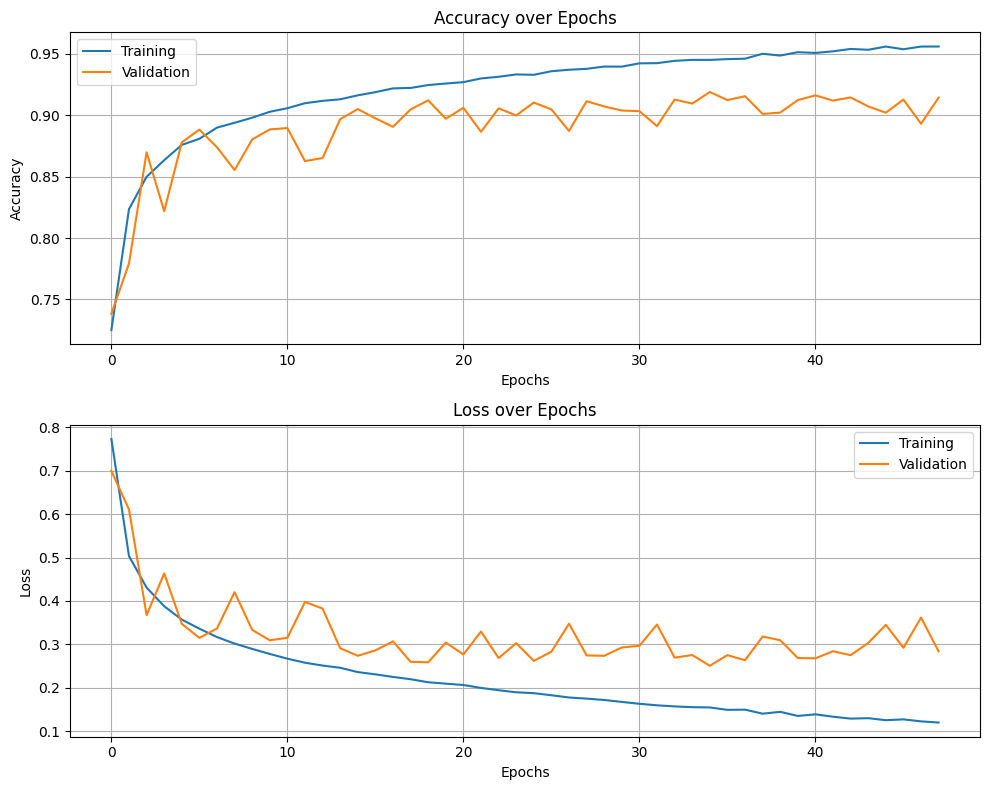

Predicted Classes [0 1 2 3 4 5 6 7 8 9]
Truth Classes [0 1 2 3 4 5 6 7 8 9]
              precision    recall  f1-score   support

     T-Shirt       0.82      0.91      0.86      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.91      0.86      0.89      1000
       Dress       0.91      0.90      0.90      1000
        Coat       0.87      0.86      0.87      1000
      Sandal       0.99      0.97      0.98      1000
       Shirt       0.74      0.74      0.74      1000
     Sneaker       0.94      0.98      0.96      1000
         Bag       0.98      0.98      0.98      1000
  Ankle Boot       0.97      0.96      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DynamicTanh(nn.Module):
    def __init__(self, num_features):
        super(DynamicTanh, self).__init__()
        # Trainable parameters a and b for Dynamic Tanh activation according to the paper
        self.a = nn.Parameter(torch.ones(num_features))
        self.b = nn.Parameter(torch.ones(num_features))

    def forward(self, x):
        # Element-wise dynamic tanh activation: a * tanh(b * x)
        # Broadcast a and b to match x's shape if necessary
        a = self.a.view(1, -1, 1, 1) if x.dim() == 4 else self.a
        b = self.b.view(1, -1, 1, 1) if x.dim() == 4 else self.b
        return a * torch.tanh(b * x)

class FashionMNISTModelwithDynamicTanh(nn.Module):
    def __init__(self, input_shape, num_classes, dropout_rate=0.5):
        super(FashionMNISTModelwithDynamicTanh, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(input_shape[0], 16, kernel_size=3, stride=1, padding=1)
        self.norm1 = nn.BatchNorm2d(16)
        self.act1 = DynamicTanh(16)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.norm2 = nn.BatchNorm2d(32)
        self.act2 = DynamicTanh(32)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.norm3 = nn.BatchNorm2d(64)
        self.act3 = DynamicTanh(64)

        self.conv4 = nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1)
        self.norm4 = nn.BatchNorm2d(96)
        self.act4 = DynamicTanh(96)

        # Global average pooling, dropout and fully connected layer
        self.globalpool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.dense = nn.Linear(96, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.act1(x)

        x = self.conv2(x)
        x = self.norm2(x)
        x = self.act2(x)

        x = self.pool(x)

        x = self.conv3(x)
        x = self.norm3(x)
        x = self.act3(x)

        x = self.conv4(x)
        x = self.norm4(x)
        x = self.act4(x)

        x = self.globalpool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.dense(x)
        return x

# Instantiate the model
model_dynamic_tanh = FashionMNISTModelwithDynamicTanh((1, 28, 28), 10)

# Summary assuming summary function is imported
summary(model_dynamic_tanh, input_size=(1, 1, 28, 28))

# Configure optimizer and loss
optimizer, criterion = configure_model(model_dynamic_tanh, optimizer_name="adam", learning_rate=0.001, loss_type="cross_entropy")

# Train the model
history_dynamic_tanh = train_model(
    model=model_dynamic_tanh,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=NEPOCHS,
    device=device,
)

# Plot training history
make_plot_history(history_dynamic_tanh)

# Evaluate model performance on test data
make_model_analysis(model_dynamic_tanh, test_images_tensor, test_labels_tensor, device=device)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.1 79658
0.7158 79658
0.918 79658
0.9116 217642
0.914 217642
0.9167 80074
0.9126 80490


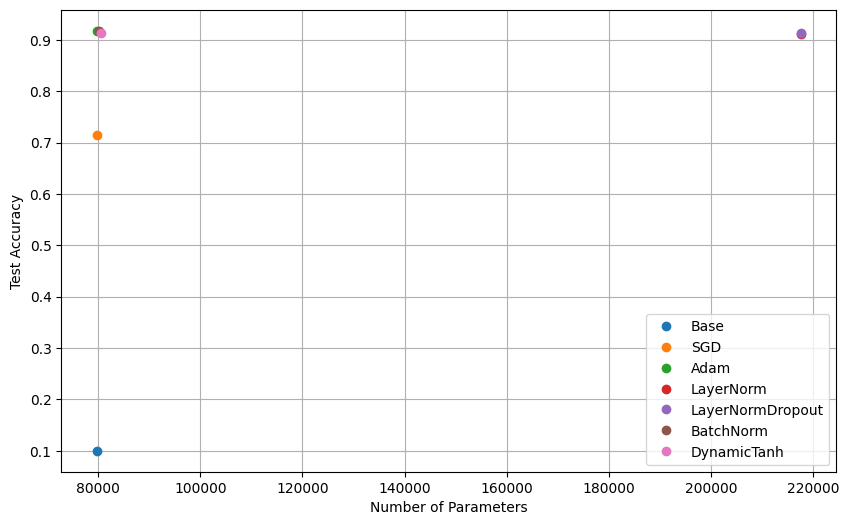

In [60]:
# Compare test accuracy and number of parameters for all models including Dynamic Tanh

list_of_models = [model0, model1, model2, model3, model4, model5, model_dynamic_tanh]
results = []

for model in list_of_models:
    # Evaluate each model on the test dataset
    acc, total_params = make_model_analysis_parameters(model, test_images_tensor, test_labels_tensor, device=device)
    results.append((acc, total_params))

# Plot test accuracy vs number of parameters for all models
labels = ['Base', 'SGD','Adam', 'LayerNorm', 'LayerNormDropout', 'BatchNorm', 'DynamicTanh']
plt.figure(figsize=(10,6))
for i in range(len(list_of_models)):
    plt.plot(results[i][1], results[i][0], 'o', label=labels[i])
plt.xlabel('Number of Parameters')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid()
plt.show()
